In [3]:
from utils import (
    compute_ndcg_similarity,
    compute_shap_similarity_pearson,
    compute_score_correlations,
    compute_pred_jaccard,
    plot_heatmaps,
    compute_auc_roc,
    load_nested_results,
)
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch

import warnings

warnings.filterwarnings("ignore")

In [4]:
all_results = load_nested_results("results/")

In [5]:
datasets_to_del = []

for dataset_name, results in all_results.items():
    auc_roc, _ = compute_auc_roc(results)

    median_auc_roc = np.nanmedian(auc_roc)
    # print(f"{dataset_name} - {median_auc_roc}")
    if median_auc_roc < 0.55 or median_auc_roc > 0.95:
        datasets_to_del.append(dataset_name)
        print(f"{dataset_name} - {median_auc_roc}")

for d in datasets_to_del:
    del all_results[d]

21_Lymphography - 0.9964285714285716
38_thyroid - 0.9526445655921953
39_vertebral - 0.4117186302070023
42_WBC - 0.98656330749354
44_Wilt - 0.4107742873751187
47_yeast - 0.41243399747230003
4_breastw - 0.9687693877915169


14_glass
15_Hepatitis
23_mammography
27_PageBlocks
29_Pima
2_annthyroid
37_Stamps
40_vowels
45_wine


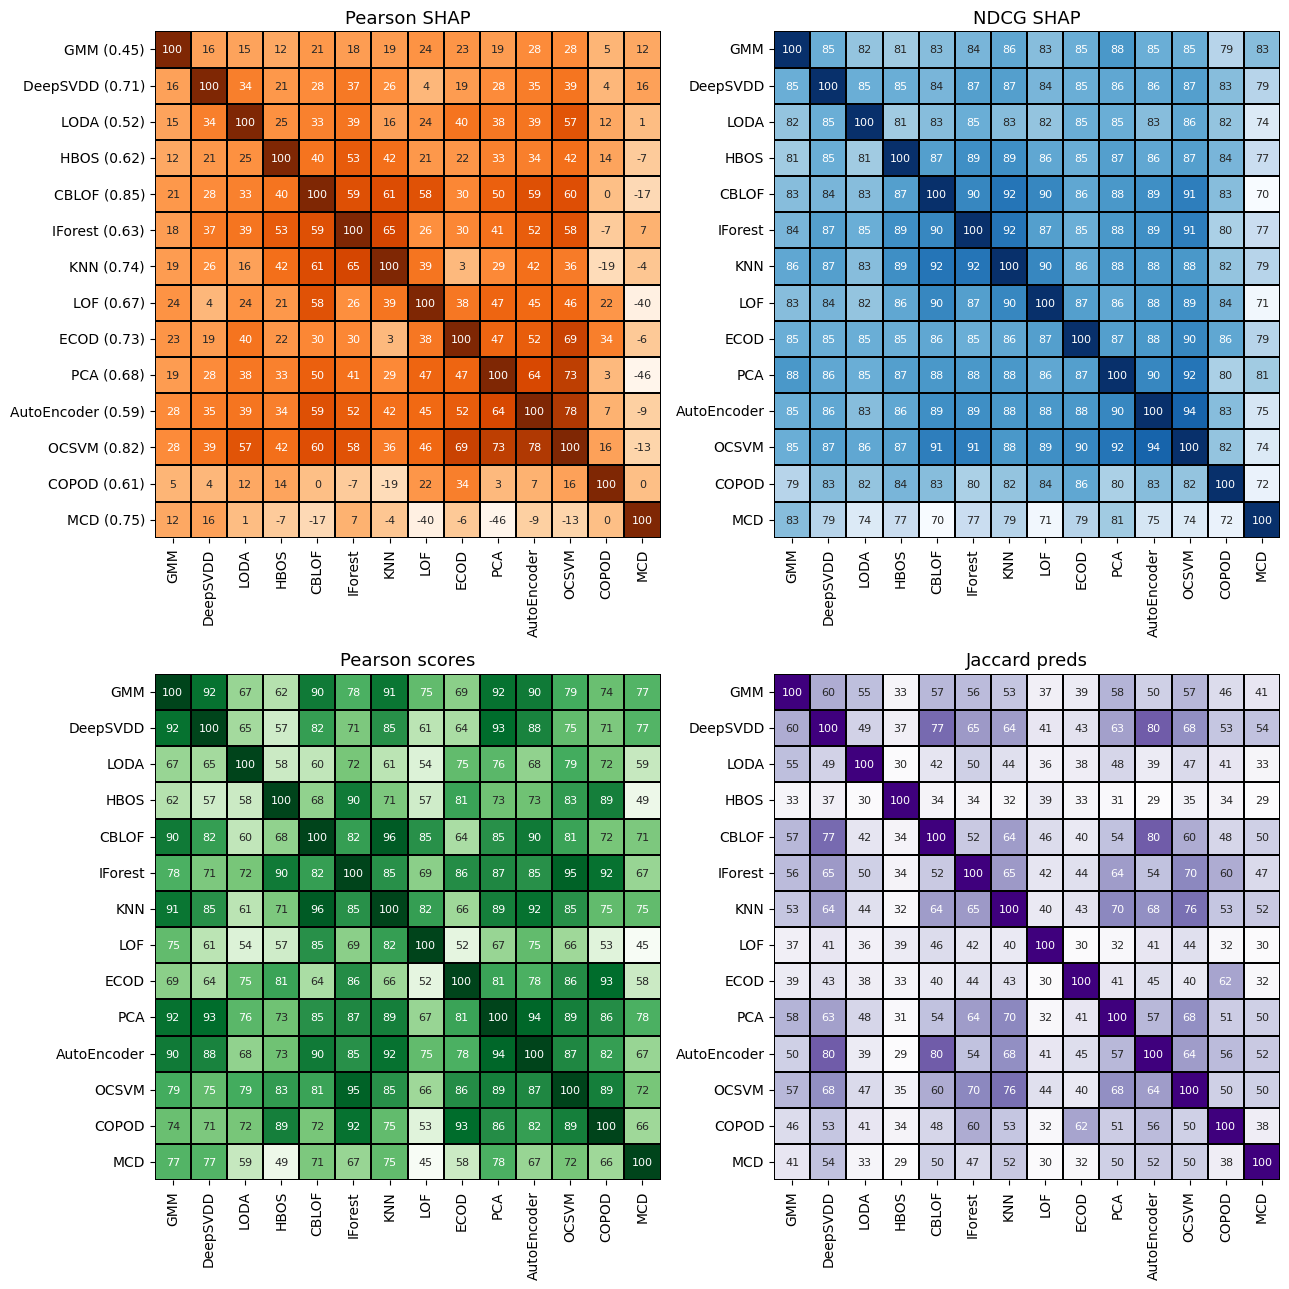

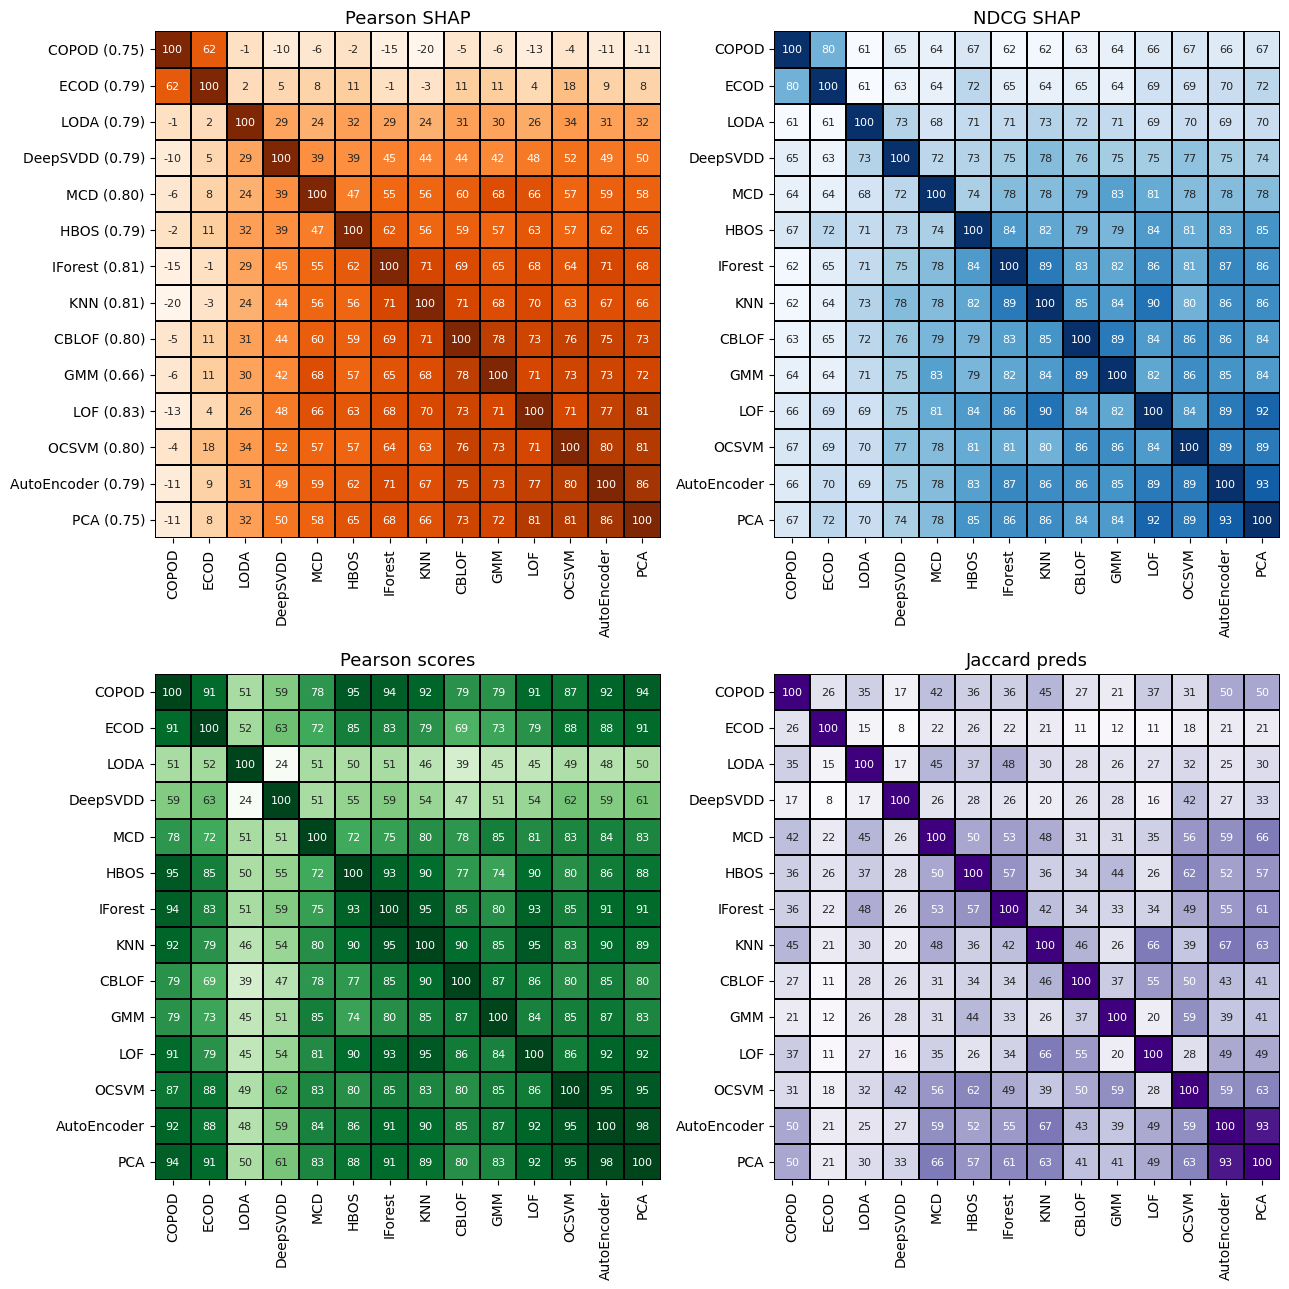

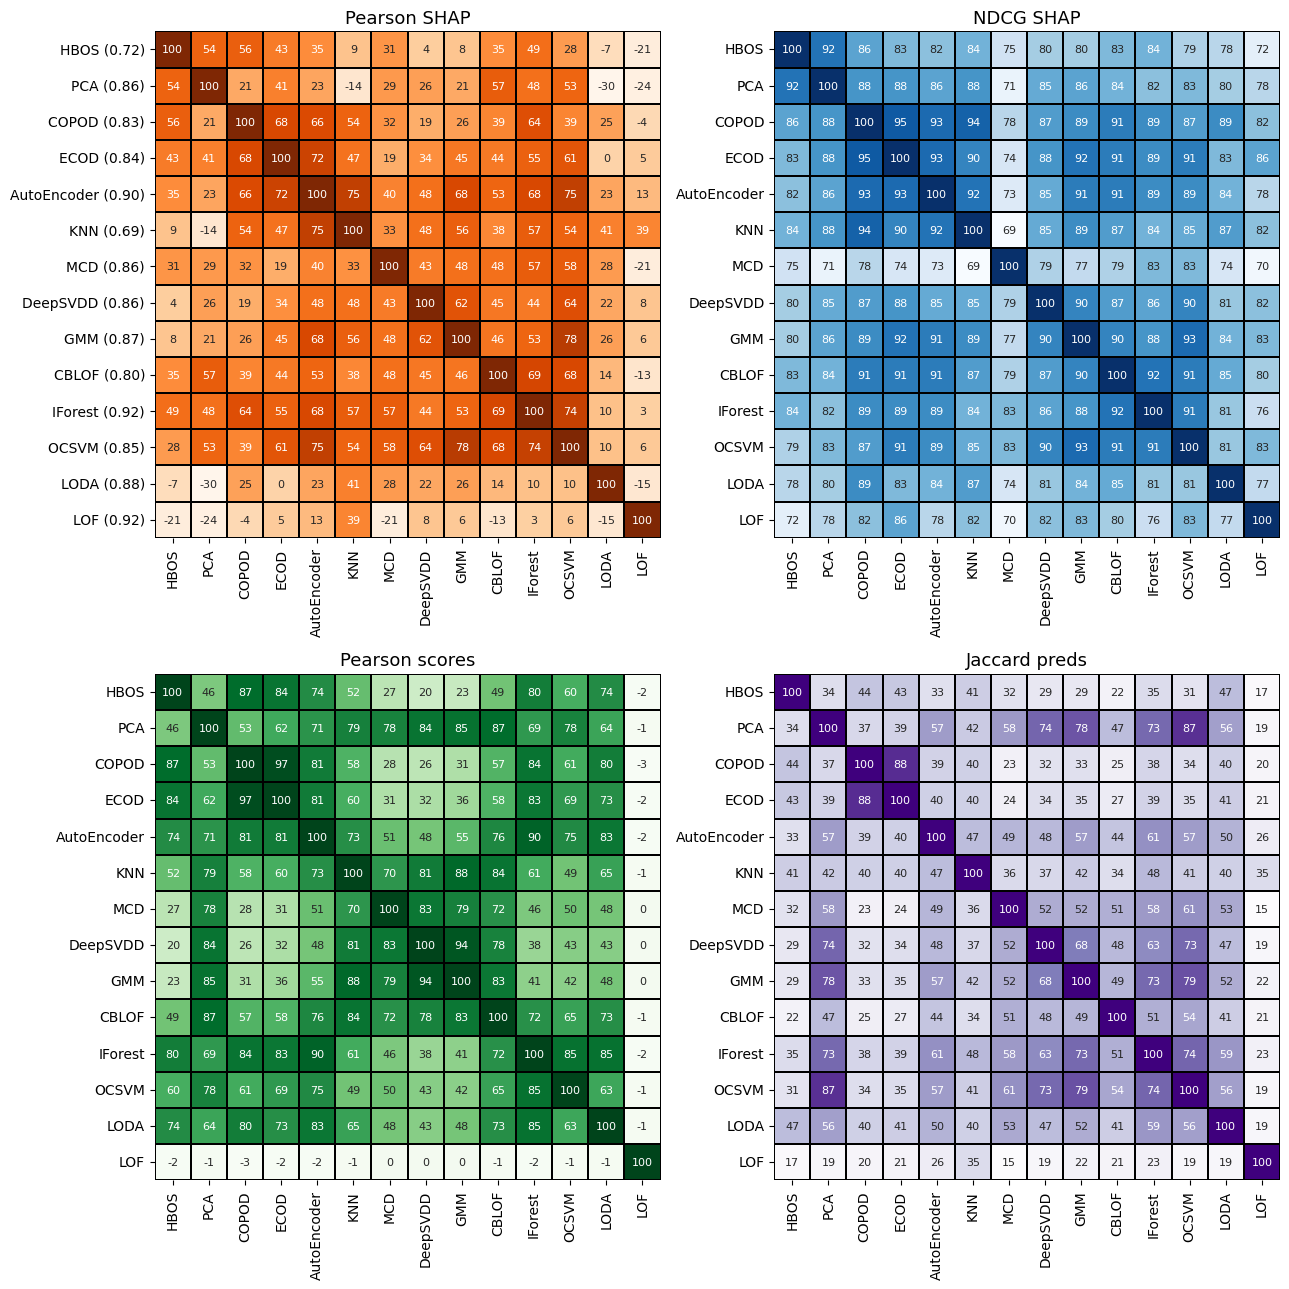

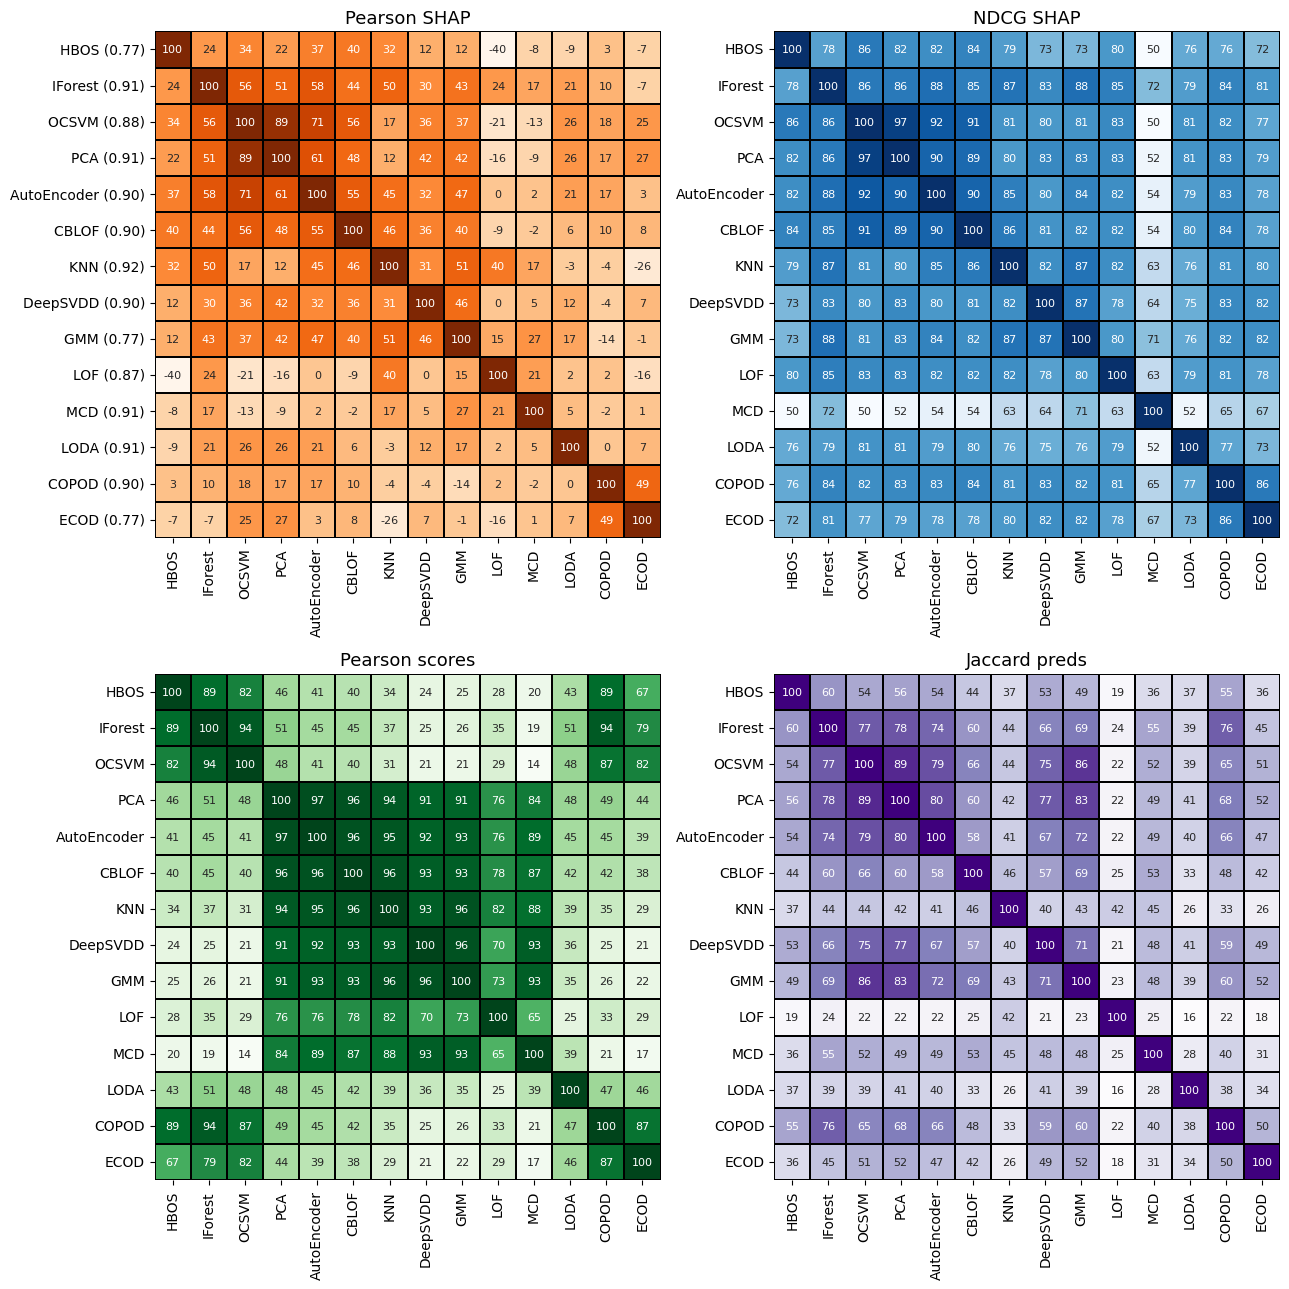

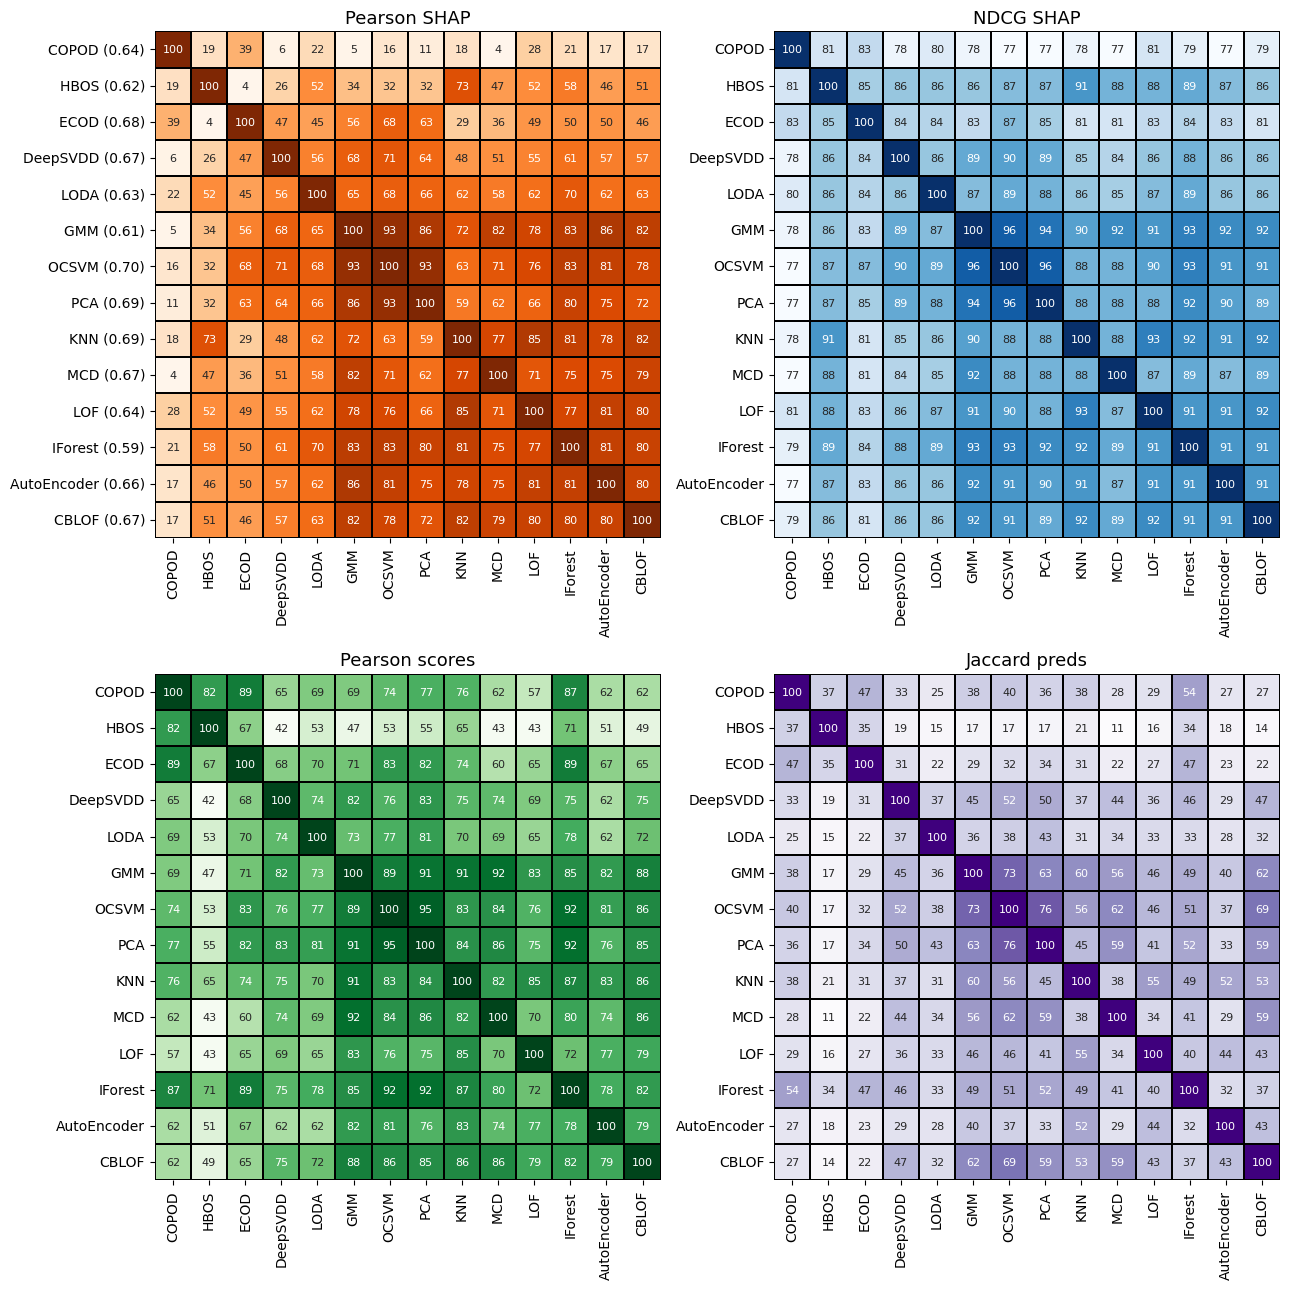

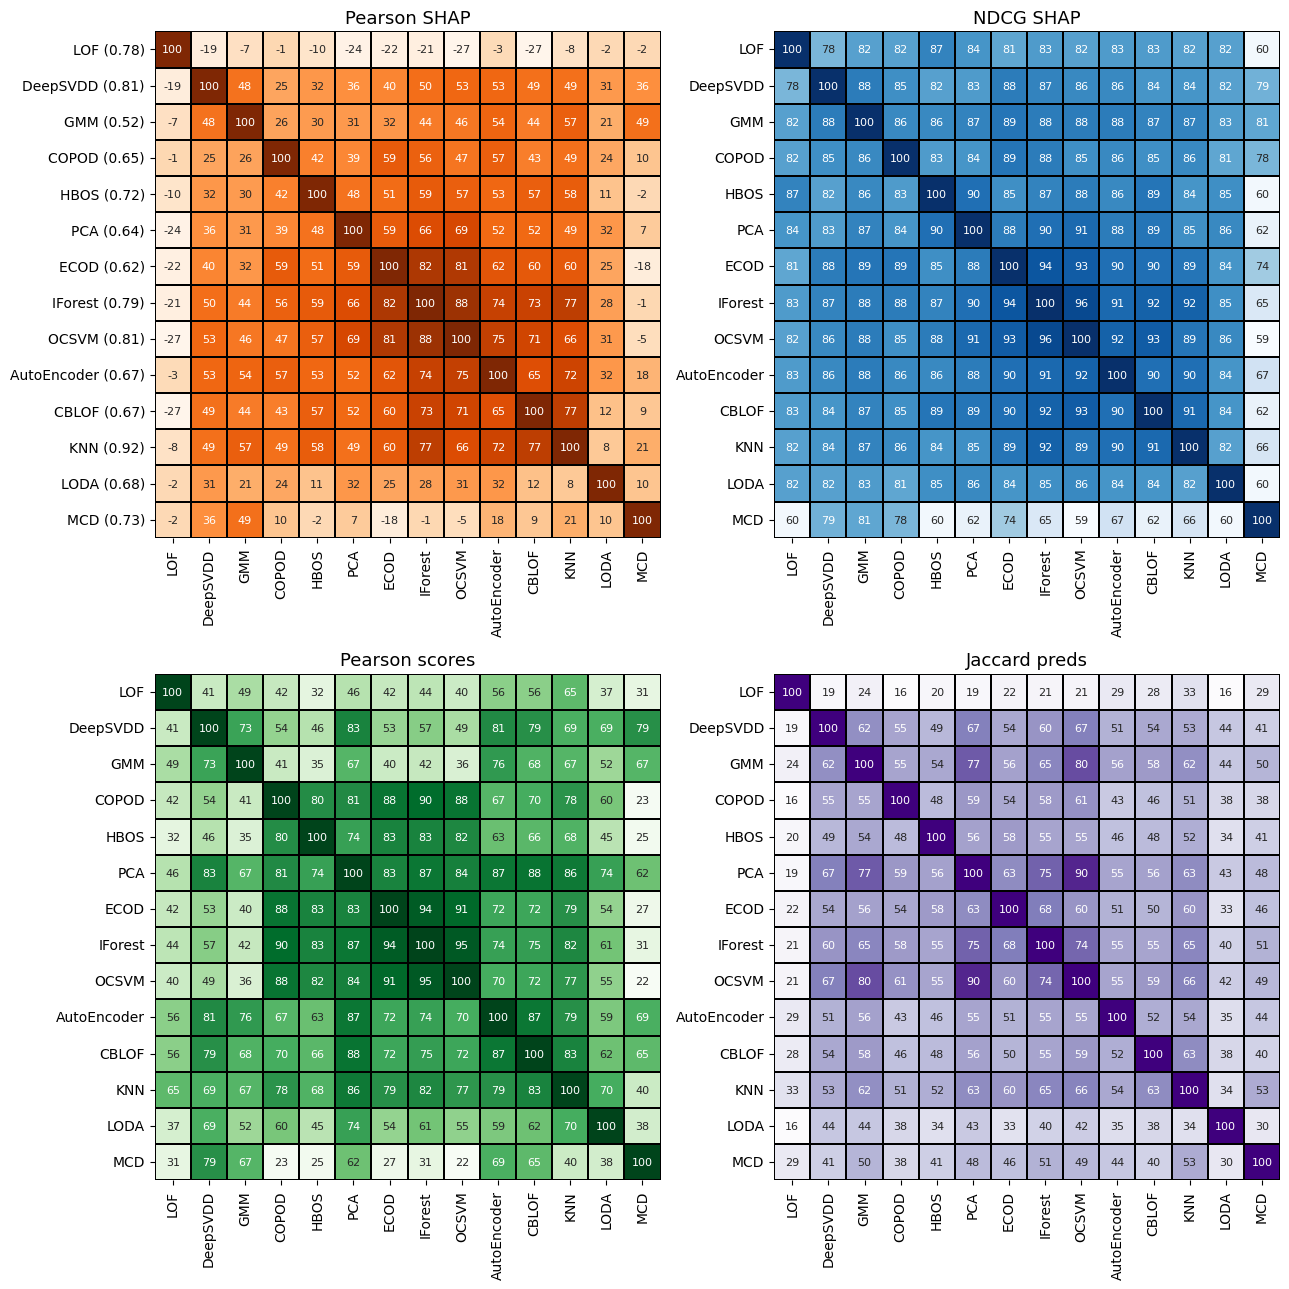

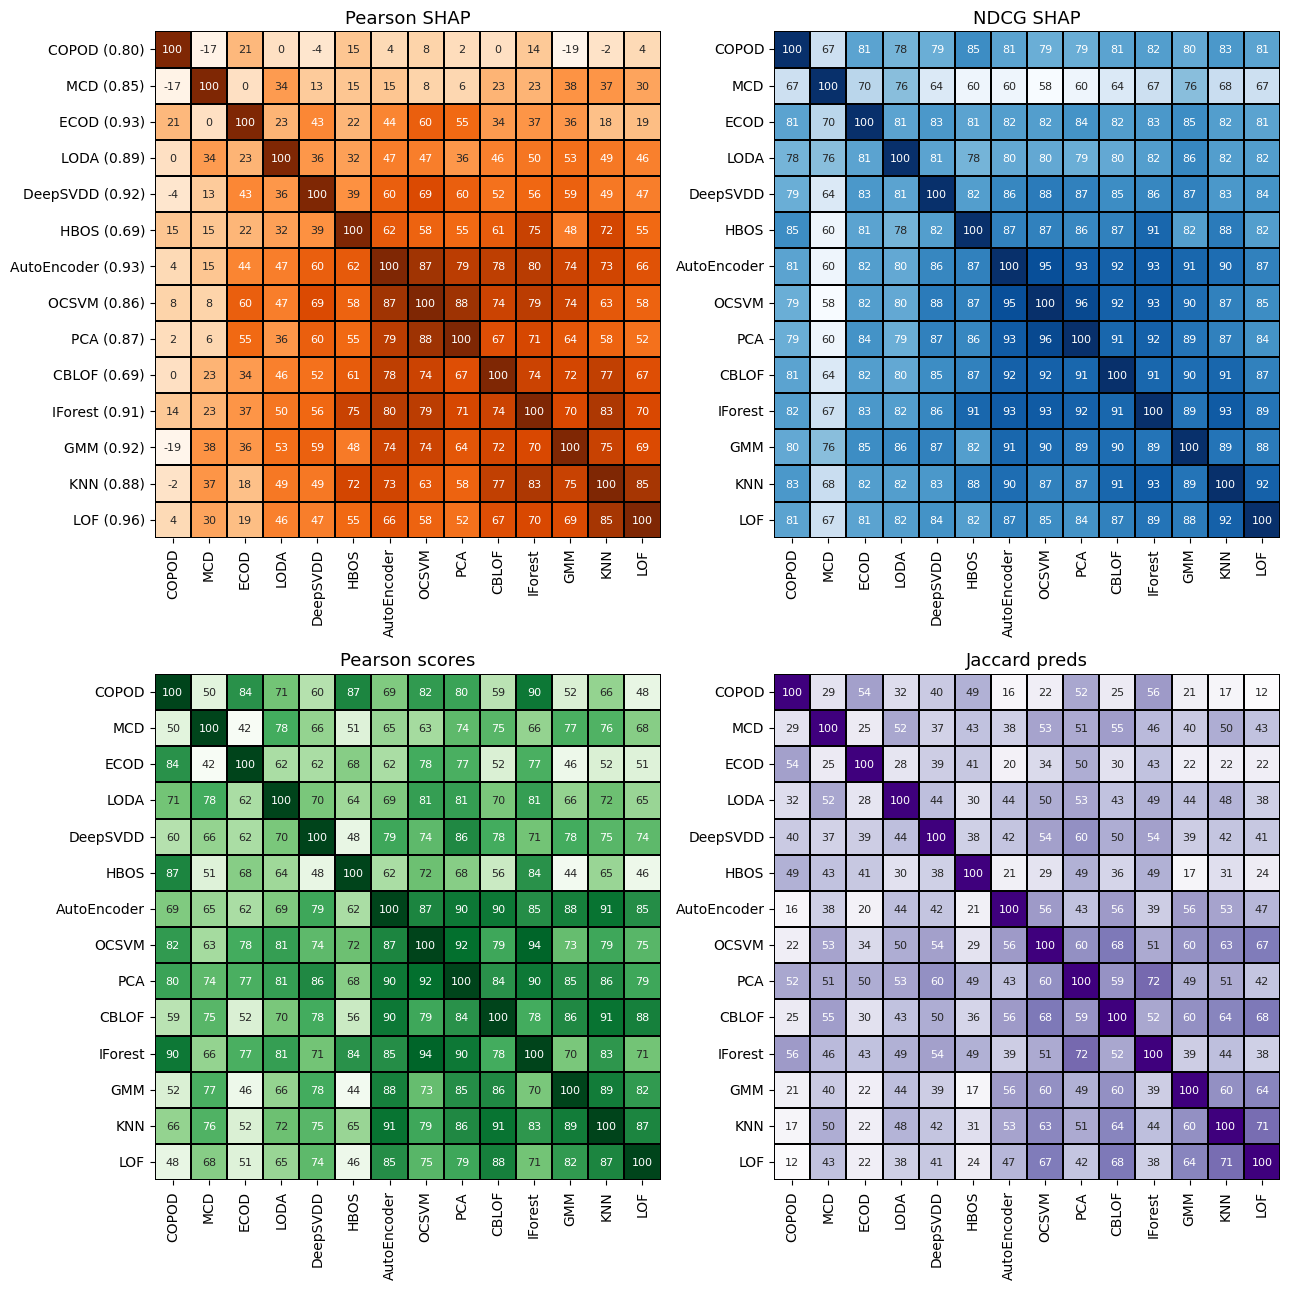

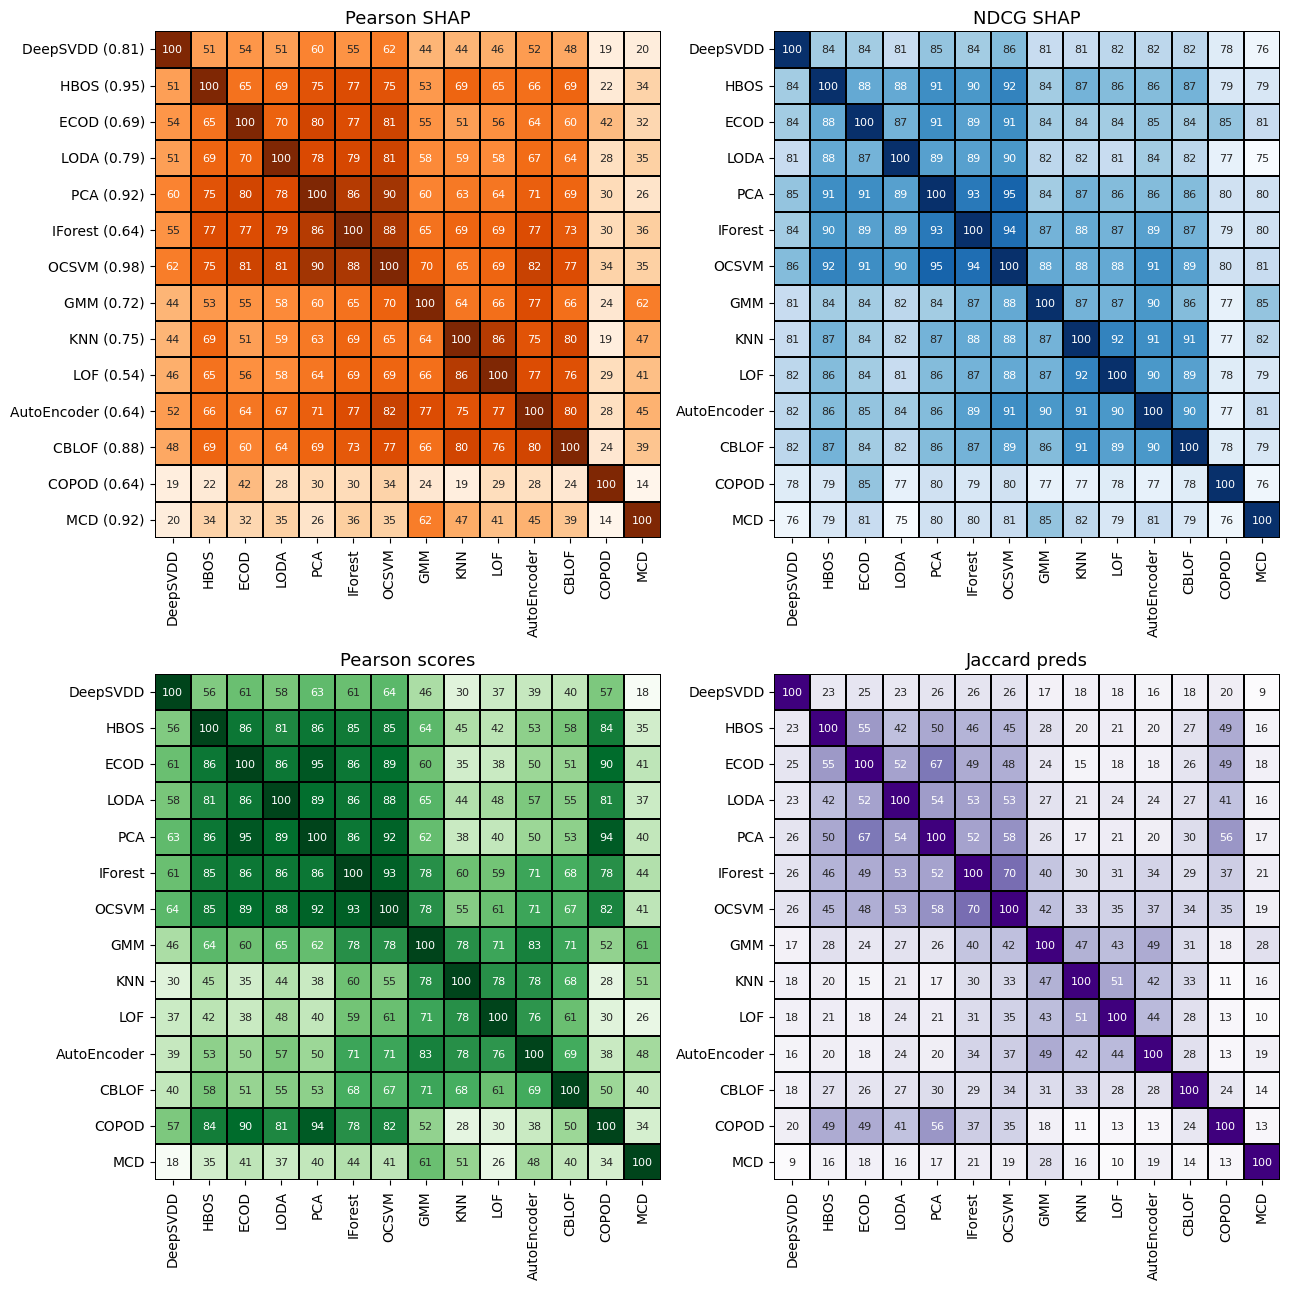

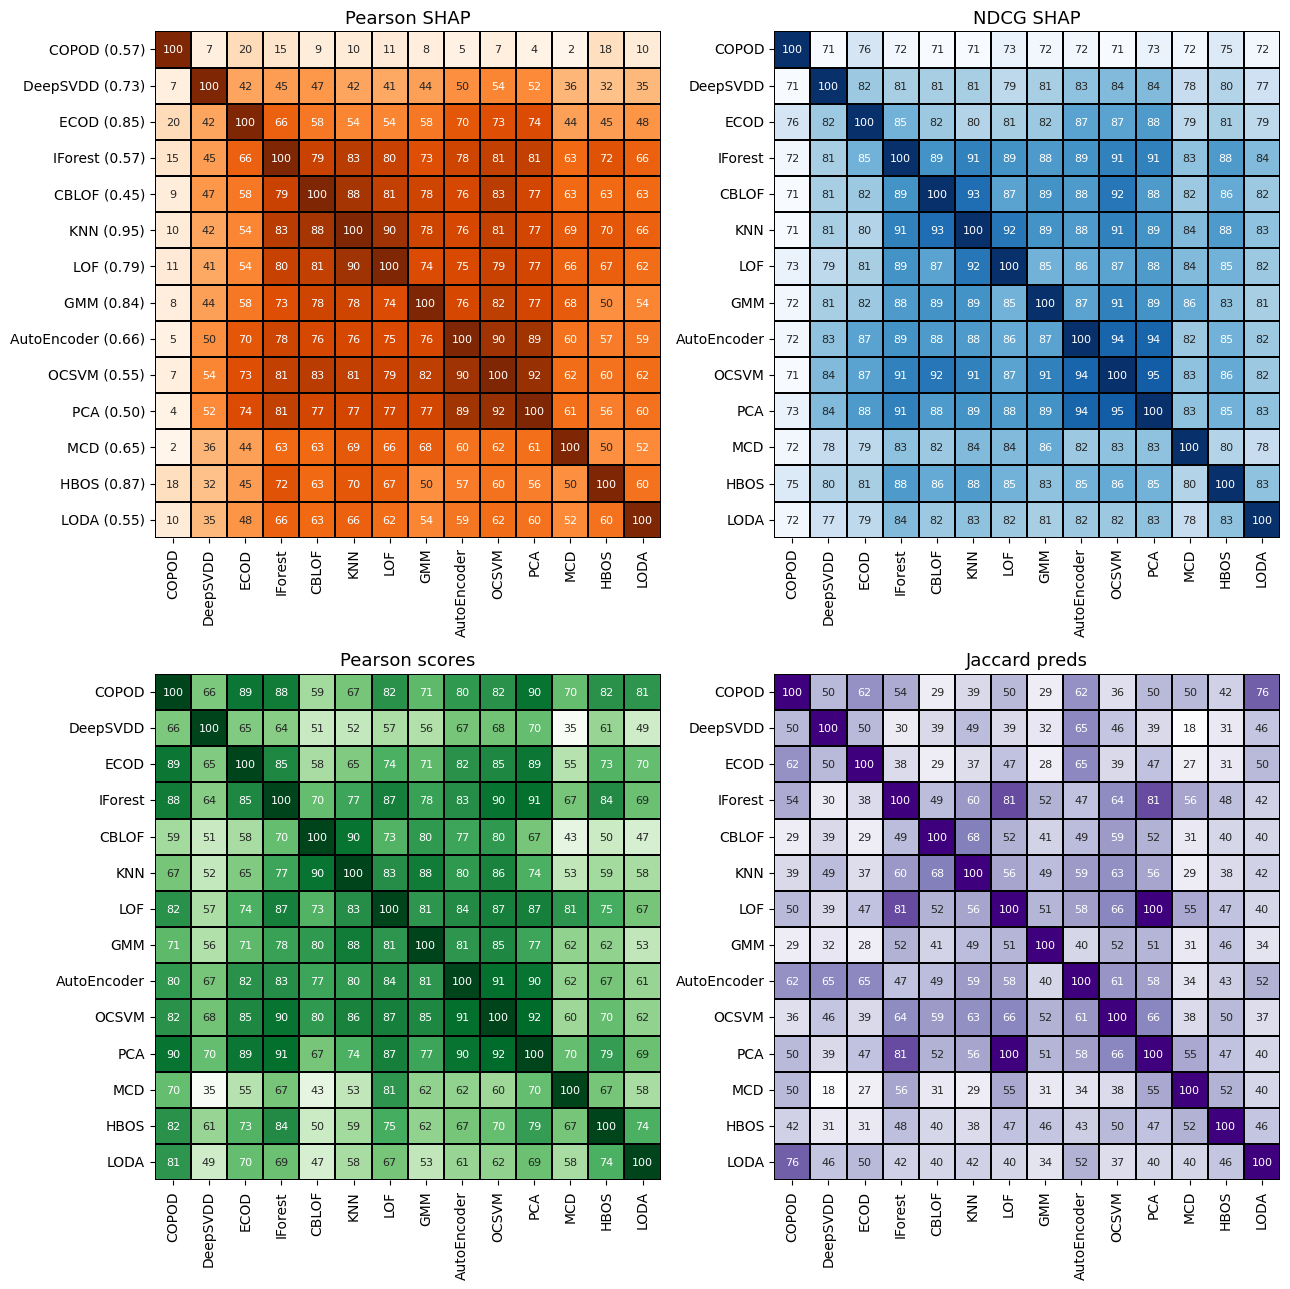

In [6]:
all_pearson = []
all_ndcg = []
all_corr_score = []
all_jaccard = []
all_aucprs = []

for dataset_name, results in all_results.items():
    print(dataset_name)

    # Compute all matrices and store them
    pearson_matrix, model_names = compute_shap_similarity_pearson(results)
    ndcg_matrix, _ = compute_ndcg_similarity(results)
    corr_score_matrix, _ = compute_score_correlations(results)
    jaccard_matrix, _ = compute_pred_jaccard(results)
    aucprs, _ = compute_auc_roc(results)

    all_pearson.append(pearson_matrix)
    all_ndcg.append(ndcg_matrix)
    all_corr_score.append(corr_score_matrix)
    all_jaccard.append(jaccard_matrix)
    all_aucprs.append(aucprs)

    df_pearson = pd.DataFrame(
        np.int32(pearson_matrix * 100), index=model_names, columns=model_names
    )
    df_ndcg = pd.DataFrame(
        np.int32(ndcg_matrix * 100), index=model_names, columns=model_names
    )
    df_corr_score = pd.DataFrame(
        np.int32(corr_score_matrix * 100), index=model_names, columns=model_names
    )

    df_jaccard_pred = pd.DataFrame(
        np.int32(jaccard_matrix * 100), index=model_names, columns=model_names
    )

    # Hierarchical clustering
    dist_matrix = 100 - df_pearson.values
    linkage = sch.linkage(dist_matrix, method="average")
    dendro = sch.dendrogram(linkage, no_plot=True)
    ordered_labels = [df_pearson.index[i] for i in dendro["leaves"]]

    df_pearson_ordered = df_pearson.loc[ordered_labels, ordered_labels]
    df_ndcg_ordered = df_ndcg.loc[ordered_labels, ordered_labels]
    df_corr_score_ordered = df_corr_score.loc[ordered_labels, ordered_labels]
    df_jaccard_pred_ordered = df_jaccard_pred.loc[ordered_labels, ordered_labels]

    # Add AUC-PR to labels
    aucprs_dict = dict(zip(model_names, aucprs))

    ordered_labels_with_mcc = [
        f"{model} ({aucprs_dict[model]:.2f})" if model in aucprs_dict else model
        for model in df_pearson_ordered.index
    ]

    df_pearson_ordered.index = ordered_labels_with_mcc

    # Plot heatmaps
    dict_heatmap = {
        "Pearson SHAP": df_pearson_ordered,
        "NDCG SHAP": df_ndcg_ordered,
        "Pearson scores": df_corr_score_ordered,
        "Jaccard preds": df_jaccard_pred_ordered,
    }

    plot_heatmaps(
        dict_heatmap,
        figsize=(13, 13),
        colormaps=["Oranges", "Blues", "Greens", "Purples", "Reds", "OrRd"],
    )

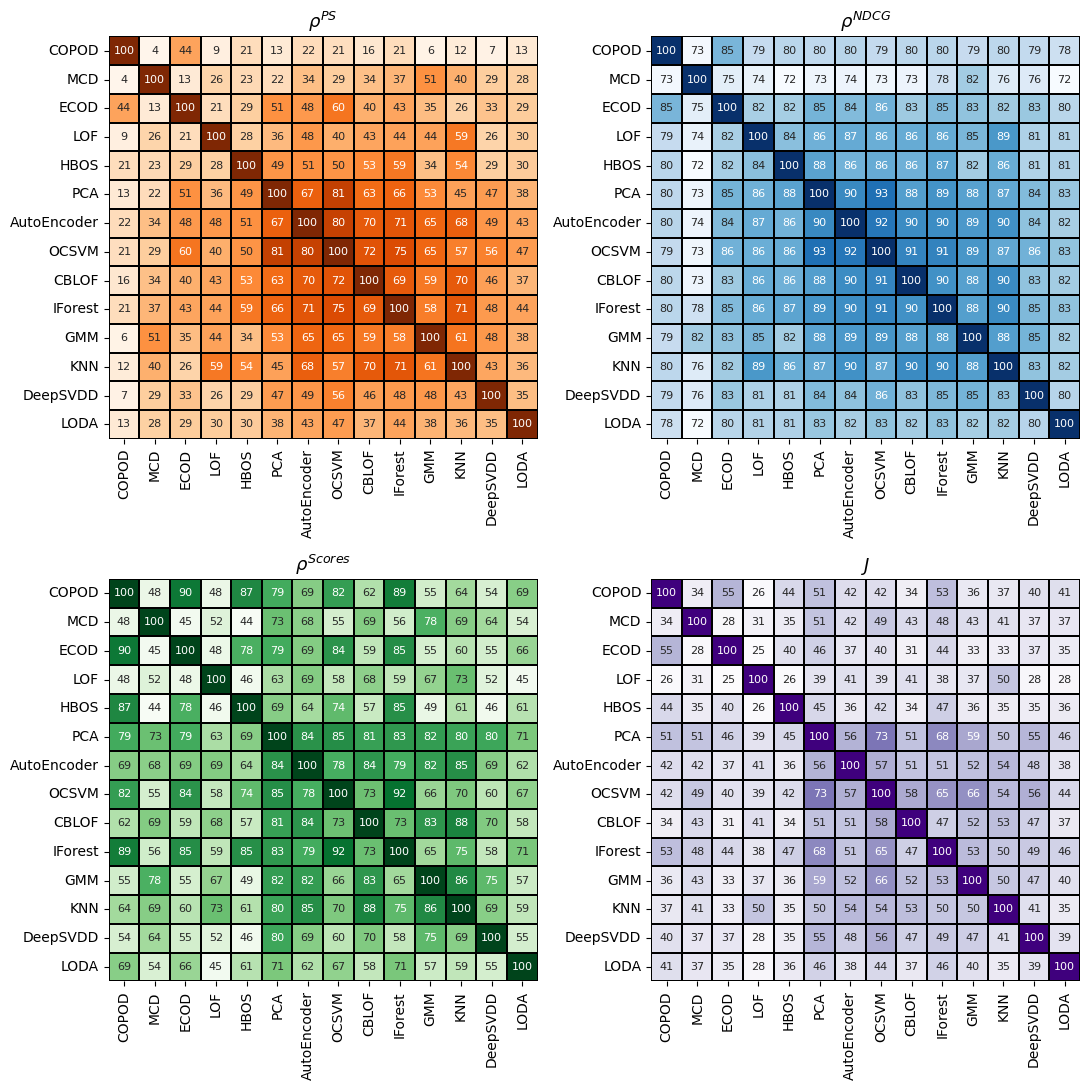

In [7]:
all_matrices = {
    "Pearson SHAP": all_pearson,
    "NDCG SHAP": all_ndcg,
    "Pearson scores": all_corr_score,
    "Jaccard preds": all_jaccard,
}

df_dict = {}
for name, mat_list in all_matrices.items():
    mean_mat = np.nanmean(np.array(mat_list), axis=0)
    df_dict[name] = pd.DataFrame(mean_mat * 100, index=model_names, columns=model_names)

dist_matrix = 100 - df_dict["Pearson SHAP"].values
linkage = sch.linkage(dist_matrix, method="average")
dendro = sch.dendrogram(linkage, no_plot=True)
ordered_labels = [df_dict["Pearson SHAP"].index[i] for i in dendro["leaves"]]

for name in df_dict:
    df_dict[name] = df_dict[name].loc[ordered_labels, ordered_labels]

mean_aucprs = np.mean(all_aucprs, axis=0)
aucprs_dict = dict(zip(model_names, mean_aucprs))

new_dict = {}
new_dict[r"$\rho^{PS}$"] = df_dict["Pearson SHAP"]
new_dict[r"$\rho^{NDCG}$"] = df_dict["NDCG SHAP"]
new_dict[r"$\rho^{Scores}$"] = df_dict["Pearson scores"]
new_dict[r"$J$"] = df_dict["Jaccard preds"]

fig = plot_heatmaps(
    new_dict,
    figsize=(11, 11),
    colormaps=["Oranges", "Blues", "Greens", "Purples", "Reds", "OrRd"],
)

fig.savefig("matrices.eps", format="eps", bbox_inches="tight", pad_inches=0.1)

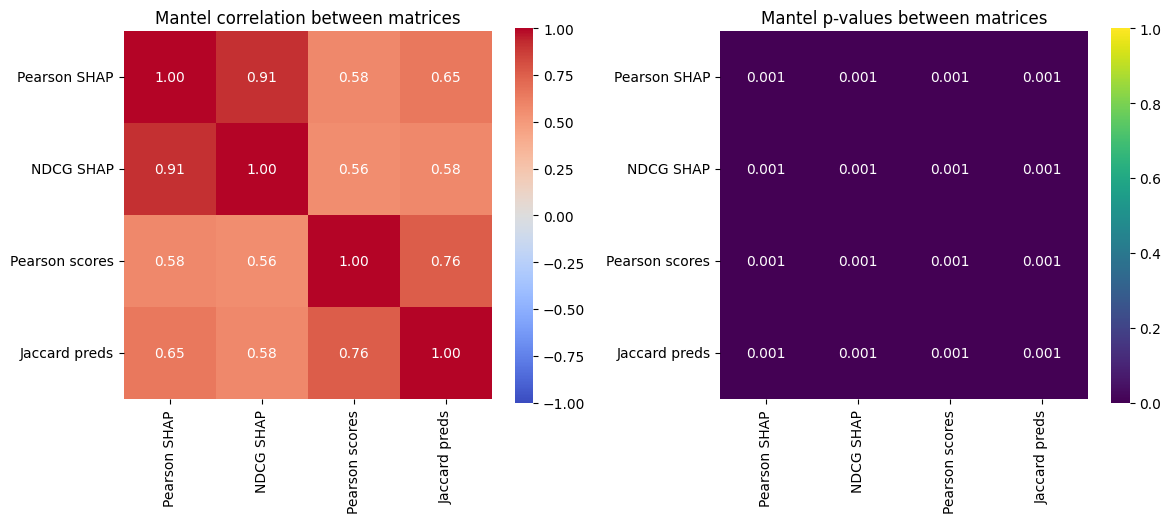

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.stats.distance import mantel

matrices_dist = [1 - np.nanmean(m, axis=0) for m in all_matrices.values()]
names = list(all_matrices.keys())

n = len(matrices_dist)
mantel_corrs = np.zeros((n, n))
mantel_pvals = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        corr, pval, _ = mantel(matrices_dist[i], matrices_dist[j], method="spearman")
        mantel_corrs[i, j] = mantel_corrs[j, i] = corr
        mantel_pvals[i, j] = mantel_pvals[j, i] = pval

df_corr = pd.DataFrame(mantel_corrs, index=names, columns=names)
df_pval = pd.DataFrame(mantel_pvals, index=names, columns=names)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    df_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    vmin=-1,
    vmax=1,
    ax=axes[0],
)
axes[0].set_title("Mantel correlation between matrices")

sns.heatmap(
    df_pval,
    annot=True,
    cmap="viridis",
    fmt=".3f",
    square=True,
    vmin=0,
    vmax=1,
    ax=axes[1],
)
axes[1].set_title("Mantel p-values between matrices")

plt.tight_layout()
plt.show()

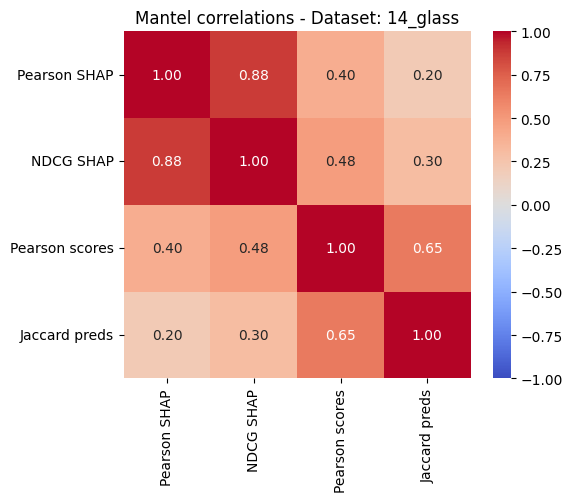

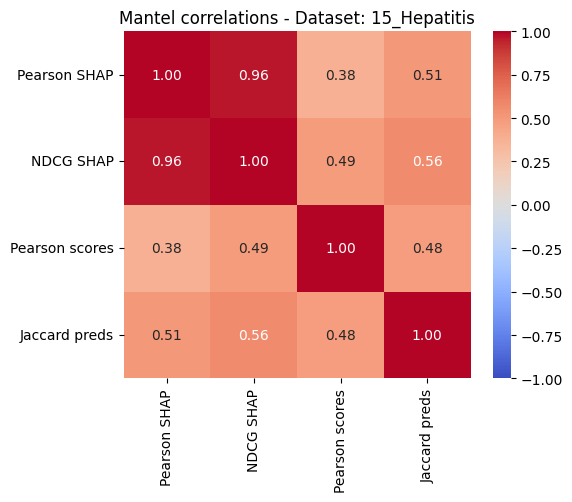

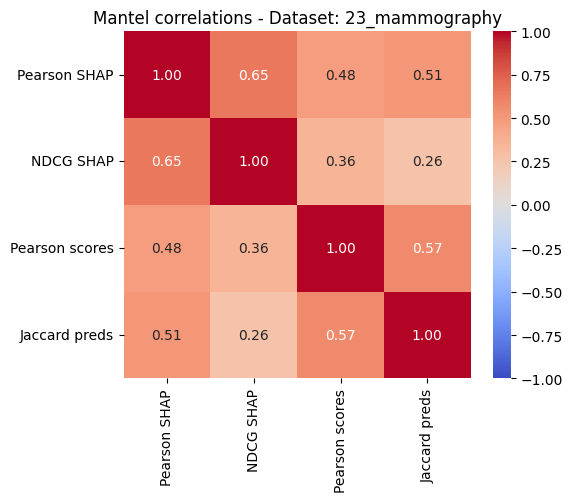

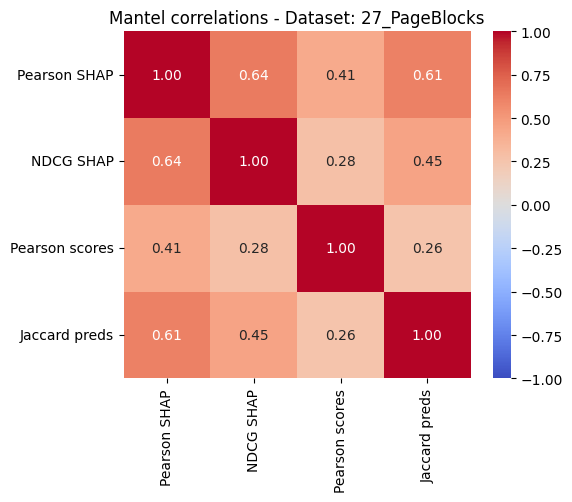

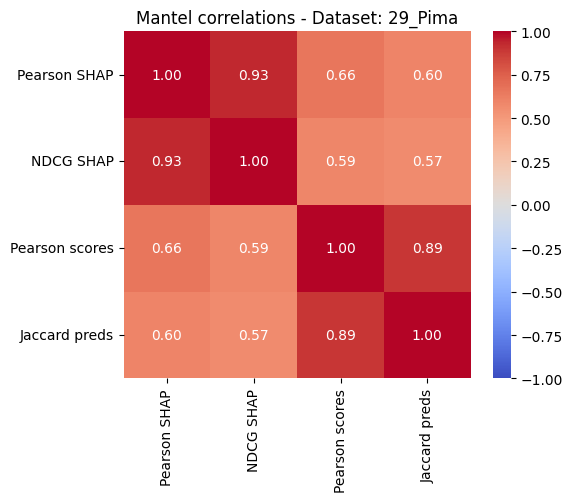

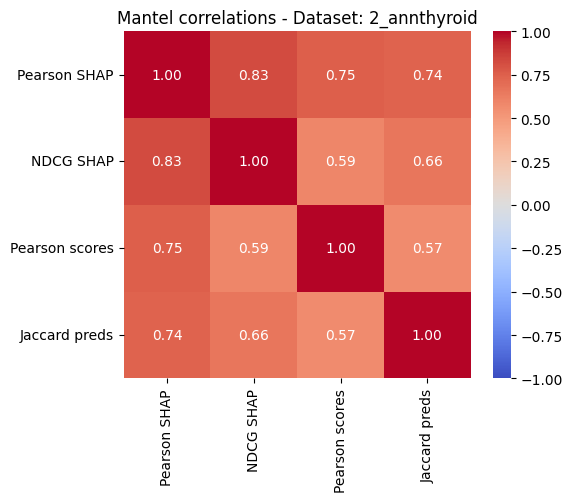

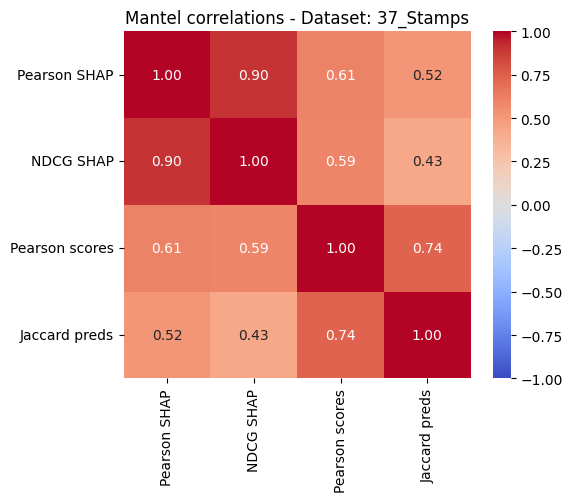

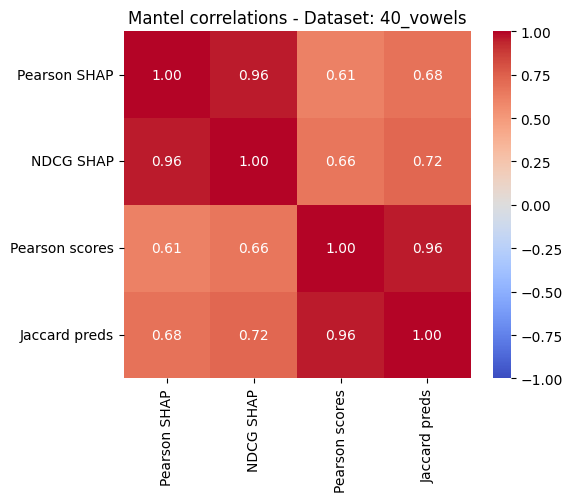

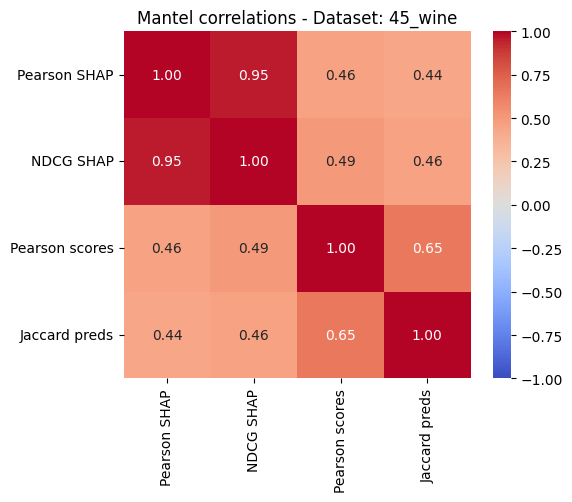



##### Mean Mantel correlations across datasets #####


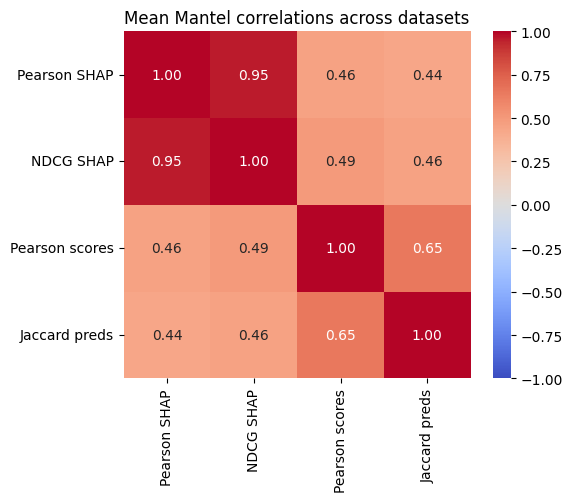

In [9]:
def plot_heatmap(df, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        df,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        square=True,
        vmin=-1,
        vmax=1,
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


dataset_names = list(all_results.keys())

all_mantel_corrs = []
all_mantel_pvals = []
for i, dataset_name in enumerate(dataset_names):

    matrices_dist = [1 - all_matrices[name][i] for name in all_matrices.keys()]

    mantel_corrs = np.zeros((n, n))
    mantel_pvals = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            corr, pval, _ = mantel(
                matrices_dist[i],
                matrices_dist[j],
                method="spearman",
                permutations=10000,
            )
            mantel_corrs[i, j] = mantel_corrs[j, i] = corr
            mantel_pvals[i, j] = mantel_pvals[j, i] = pval

    all_mantel_corrs.append(mantel_corrs)
    all_mantel_pvals.append(mantel_pvals)

    df_mean_corr = pd.DataFrame(mantel_corrs, index=names, columns=names)
    plot_heatmap(df_mean_corr, f"Mantel correlations - Dataset: {dataset_name}")

print("\n\n##### Mean Mantel correlations across datasets #####")

mean_all_mantel_corrs = np.mean(np.array(all_mantel_corrs), axis=0)
df_mean_corr = pd.DataFrame(mantel_corrs, index=names, columns=names)
plot_heatmap(df_mean_corr, "Mean Mantel correlations across datasets")